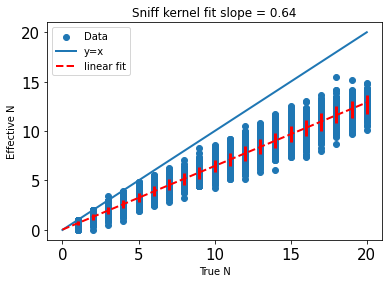

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import linregress
import os
# Load data
# change working directory
#os.chdir('/Users/farhad/Dropbox/AllCodes/CodesHarvard/CountingPCx/')
behav = loadmat('behaviour_data.mat')
d = pd.read_csv('behavioral_data_for_Farhad_with_eff_odor.csv')

# Initialize variables
xopts = []
xoptsX = []
ns = np.arange(1, 21)
nNs = []
ia = 0
y = []

if ia == 0:
    for ni in range(1, 21):
        nNs.append(np.sum(behav['pooled_pulse_counts'] == ni))
        #y.append(behav['Phighs_pooled_mean'][behav['NsUnique'] == ni].flatten())
        y.append(behav['Phighs_pooled_mean'].flatten()[np.where(behav['NsUnique'] == ni)[0][0]])
    idx = np.where((d['Total Pulse'] < 21) & (d['Total Pulse'] > 0) & (d['Animal'] > -1))[0]
else:
    idx = np.where((d['Animal'] == ia - 1) & (d['Total Pulse'] < 21) & (d['Total Pulse'] > 0))[0]
    y = []
    for ni in range(1, 21):
        y.append(behav['PhighAnimals'][ia - 1, behav['NsUnique2'] == ni].flatten())

# Process the data for the main figure plot
Nis = d['Total Pulse'].iloc[idx].values
yis = d['High Choice'].iloc[idx].values
wNs = d['Effective_odor'].iloc[idx].values
Nisorig0 = Nis; yisorig = yis;

# Plotting
plt.figure()
plt.scatter(Nis, wNs)
plt.xlabel('True N')
plt.ylabel('Effective N')
plt.plot([0, 20], [0, 20], '-', linewidth=2)
plt.grid(which='minor', linestyle='--')

p = np.polyfit(Nis, wNs, 1)
# Linear fit
slope, intercept, _, _, _ = linregress(Nis, wNs)
x_fit = np.linspace(0, 20, 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'r--', linewidth=2)
plt.title(f'Sniff kernel fit slope = {slope:.2f}')

# Error bars for each ni
for ni in range(1, 21):
    ni_idx = np.where(Nis == ni)[0]
    if len(ni_idx) > 0:
        plt.errorbar(ni, np.mean(wNs[ni_idx]), yerr=np.std(wNs[ni_idx]), color='r', linewidth=3)

plt.legend(['Data', 'y=x', 'linear fit'])
plt.gca().tick_params(axis='both', which='major', labelsize=15)
plt.show()


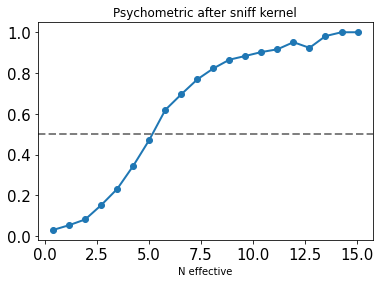

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
NbinsW = 20

# Generate bin edges and bin centers
edges = np.linspace(0, np.max(wNs), NbinsW + 1)
binWcenters = (edges[1:] + edges[:-1]) / 2

# Bin the effective N values
wbinid = np.digitize(wNs, edges)  
Nisorig = wbinid

# Calculate psychometric values by bin
ypsy = []
for ni in range(1,NbinsW+1):
    bin_indices = np.where(Nisorig == ni)[0]
    if bin_indices.size > 0:
        ypsy.append(np.mean(yis[bin_indices]))
    else:
        ypsy.append(np.nan)  # Handle empty bins if necessary

# Plot the psychometric curve
plt.figure()
plt.plot(binWcenters, ypsy, '-o', linewidth=2)
plt.title('Psychometric after sniff kernel')
plt.xlabel('N effective')
plt.axhline(0.5, linestyle='--', color='grey', linewidth=2)
plt.grid(which='minor', linestyle='--')
plt.gca().tick_params(axis='both', which='major', labelsize=15)
plt.show()

#

In [7]:
print(p)

[0.64344565 0.0295804 ]


N effective (zero-crossing) = 5.012123449928178


/var/folders/xy/wcn_mfbd55s9g3lg4nhmyp_m0000gn/T/ipykernel_94578/906117250.py:8: RuntimeWarning: divide by zero encountered in true_divide
  F = lambda x, N: 0.5 * (1 + erf((N - x[-2]) / np.sqrt(2 * (x[np.round(N).astype(int) - 1] ** 2 + x[-1] ** 2))))  # Phigh function
/var/folders/xy/wcn_mfbd55s9g3lg4nhmyp_m0000gn/T/ipykernel_94578/906117250.py:37: RuntimeWarning: divide by zero encountered in log
  loglikelihood = lambda x: -np.nanmean(np.log(F(x, Nis)) * yis + np.log(1 - F(x, Nis)) * (1 - yis))
/var/folders/xy/wcn_mfbd55s9g3lg4nhmyp_m0000gn/T/ipykernel_94578/906117250.py:37: RuntimeWarning: invalid value encountered in multiply
  loglikelihood = lambda x: -np.nanmean(np.log(F(x, Nis)) * yis + np.log(1 - F(x, Nis)) * (1 - yis))


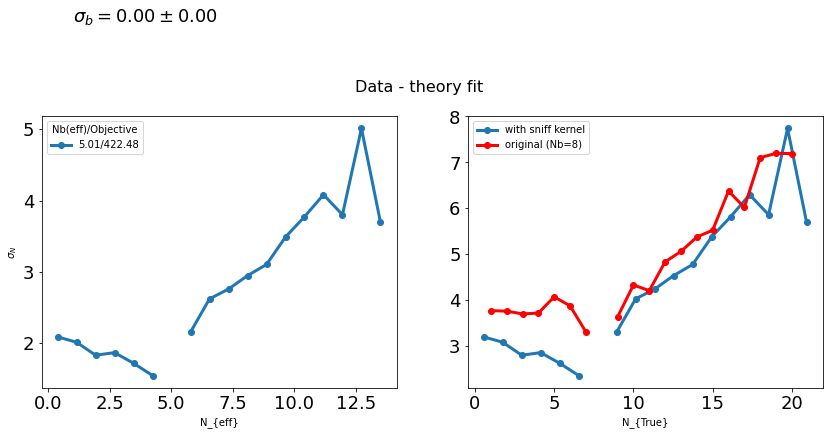

In [12]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from numpy.random import choice

# Parameters
k = np.arange(1, NbinsW + 1)
F = lambda x, N: 0.5 * (1 + erf((N - x[-2]) / np.sqrt(2 * (x[np.round(N).astype(int) - 1] ** 2 + x[-1] ** 2))))  # Phigh function
xall_data_theory = []
lks = []
Nboot = 0
numNbs = 1

idxboot = np.arange(len(yisorig))

    
Nis = Nisorig[idxboot]
yis = yisorig[idxboot]

# Find average psychometric for this bootstrap
yboot = []
for ni in range(1, NbinsW + 1):
    ni_indices = np.where(Nis == ni)[0]
    yboot.append(np.mean(yis[ni_indices]) if ni_indices.size > 0 else np.nan)

yboot = np.array(yboot)

Nb = np.argsort(np.abs(yboot-0.5))[0] + 1  # Find the closest bin to 0.5
Nbs = [Nb]
for Nb in Nbs:
    sigmab = 0
    sigmaNs = np.sqrt(((k - Nb) / erfinv(2 * yboot - 1)) ** 2 / 2 - sigmab ** 2)
    sigmaNs[np.where(k == Nb)] = np.nan  # Exclude sigmaNs for integers

    # Construct x and calculate log-likelihood
    x = np.concatenate([sigmaNs, [Nb, sigmab]])
    loglikelihood = lambda x: -np.nanmean(np.log(F(x, Nis)) * yis + np.log(1 - F(x, Nis)) * (1 - yis))
    lks.append(loglikelihood(x) * 1000)
    xall_data_theory.append(x)
        
xall_data_theory = np.array(xall_data_theory)
lks = np.array(lks)

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i in range(xall_data_theory.shape[0]):
    # Calculate sigmaNeffective using interpolation
    interp_sigmaN = interp1d(k, binWcenters, bounds_error=False, fill_value=None)
    #print(interp_sigmaN)
    sigmaNeffective = interp_sigmaN(xall_data_theory[i, :NbinsW])

    # Plot in the first subplot (Effective N space)
    ax1.plot(binWcenters, sigmaNeffective, '-o', linewidth=3)
    
    # Calculate sigmaNeffective in terms of True N
    binWcenters_inTrueN = binWcenters / p[0] - p[1] / p[0]
    sigmaNeffective_inTrueN = sigmaNeffective / p[0] - p[1] / p[0]
    
    # Plot in the second subplot (True N space)
    ax2.plot(binWcenters_inTrueN, sigmaNeffective_inTrueN, '-o', linewidth=3, label = 'with sniff kernel')

#print(sigmaNeffective)

# Set titles and labels for both subplots
fig.suptitle('Data - theory fit', fontsize=16)
ax1.set_xlabel('N_{eff}')
ax2.set_xlabel('N_{True}')
ax1.set_ylabel(r'$\sigma_N$')
ax1.grid(True, which='minor')
ax2.grid(True, which='minor')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

# Display sigma_b text annotation in the first subplot
sigma_b_mean = np.mean(xall_data_theory[:, -1])
sigma_b_std = np.std(xall_data_theory[:, -1])
ax1.text(1, 6.5, rf'$\sigma_b={sigma_b_mean:.2f} \pm {sigma_b_std:.2f}$', fontsize=18)

# Calculate Nbeffective for legends
Nbeffective = interp_sigmaN(xall_data_theory[:, -2])

# Add legends
legend1 = ax1.legend([f'{Nbe:.2f}/{lk:.2f}' for Nbe, lk in zip(Nbeffective, lks)], title='Nb(eff)/Objective')
legend2 = ax2.legend([f'{(Nbe / p[0] - p[1] / p[0]):.2f}/{lk:.2f}' for Nbe, lk in zip(Nbeffective, lks)], title='Nb(true)/Objective')

# Calculate Nbzeroeffective using interpolation and display the result
Nbzeroeffective = interp_sigmaN(Nb)
print(f'N effective (zero-crossing) = {Nbzeroeffective}')

SigmaNoKernel = [3.77278509803074,3.76263311602848,3.70149571539860,3.71996791956855,4.07433810570134,3.87653653461171,3.31178408087192,np.nan,3.63728578600175,	4.33208906750056,	4.20816804325424,	4.83570269768384,	5.06156212269731,	5.37541021237242,	5.52389668918809,	6.37664244963467,	6.02045751161965,	7.10405456799167,	7.19751530171325,7.19255774277399];
ax2.plot(np.arange(1,21),SigmaNoKernel,'-or',lw = 3, label = 'original (Nb=8)')
ax2.legend()

plt.show()



In [4]:
# Old code with the ability to change Nb
# import numpy as np
# from scipy.interpolate import interp1d
# from scipy.special import erf, erfinv
# from numpy.random import choice

# # Parameters
# k = np.arange(1, NbinsW + 1)
# F = lambda x, N: 0.5 * (1 + erf((N - x[-2]) / np.sqrt(2 * (x[np.round(N).astype(int) - 1] ** 2 + x[-1] ** 2))))  # Phigh function
# xall_data_theory = []
# lks = []
# Nboot = 0
# numNbs = 1

# for i in range(Nboot + 1):
#     # Bootstrapping index
#     if i == 0:
#         idxboot = np.arange(len(yisorig))
#     else:
#         idxboot = choice(len(yisorig), len(yisorig), replace=True)
    
#     Nis = Nisorig[idxboot]
#     yis = yisorig[idxboot]

#     # Find average psychometric for this bootstrap
#     yboot = []
#     for ni in range(1, NbinsW + 1):
#         ni_indices = np.where(Nis == ni)[0]
#         yboot.append(np.mean(yis[ni_indices]) if ni_indices.size > 0 else np.nan)
    
#     yboot = np.array(yboot)

#     # Interpolation to find Nzerocrossing
#     nsq = np.arange(1, NbinsW, 0.01)
#     interp_func = interp1d(k, yboot, kind='linear', bounds_error=False, fill_value="extrapolate")
#     yq = interp_func(nsq)
#     Nzerocrossing = nsq[np.argmin(np.abs(yq - 0.5))]
#     Nb = Nzerocrossing
    
#     #Nb = 5.01 

#     # Alternate method for Nb
#     Nb = np.interp((p[0] * 8 + p[1]), binWcenters, k)

#     # Testing range of Nb values
#     if numNbs > 1:
#         Nbs = np.linspace(np.floor(Nb) + 0.01, np.floor(Nb) + 0.99, numNbs)
#         # Uncomment to include the integer bounds, e.g., 7 and 8
#         Nbs = np.linspace(np.floor(Nb), np.floor(Nb) + 1, numNbs)
#     else:
#         Nbs = [Nb]
#         Nbs = [np.argsort(np.abs(yboot-0.5))[0] + 1] # Find the closest bin to 0.5
#     for Nb in Nbs:
#         sigmab = 0
#         sigmaNs = np.sqrt(((k - Nb) / erfinv(2 * yboot - 1)) ** 2 / 2 - sigmab ** 2)
#         sigmaNs[np.where(k == Nb)] = np.nan  # Exclude sigmaNs for integers

#         # Construct x and calculate log-likelihood
#         x = np.concatenate([sigmaNs, [Nb, sigmab]])
#         loglikelihood = lambda x: -np.nanmean(np.log(F(x, Nis)) * yis + np.log(1 - F(x, Nis)) * (1 - yis))
#         lks.append(loglikelihood(x) * 1000)
#         xall_data_theory.append(x)
        
# xall_data_theory = np.array(xall_data_theory)
# lks = np.array(lks)
